# CS 363M Project

## Names: Gabby Galicinao, Andrea Toba, Angela Cheng, Ruchi Shah

## The Problem
<br>
Movies are one of the most popular sources of entertainment and affect a country's society, culture, and national happiness/wellbeing. We will analyze IMDb data to gain a better understanding of the factors that make movies well received by their audiences. These results can be used by movie producers and film companies to better understand the factors needed to create a great movie, as well as by the audiences to better predict if certain movies are worth watching.
<br><br>
In this project, we will attempt to classify movies by their IMDb score (a continous value from 0-worst to 10-best), using the Movie Industry dataset (https://www.kaggle.com/datasets/danielgrijalvas/movies). In the initial dataset, there are 7,668 records and 15 attributes (some categorical, some continuous).

<br>**Attribute Information:** 
- name: name of the film
- rating: G, PG, PG-13, R
- genre: comedy, action, etc.
- year: release year
- released: date of release (including the month, day, and year) and country of origin
- votes: count of IMDb user votes
- director: name of director of the film
- writer: name of the writer of the film
- star: the main actor/actress of the film
- country: the film's country of origin
- budget: amount of money used to create the film
- gross: amount of money made from the film
- company: name of production company
- runtime: length of film in minutes
- score: IMDb user rating (class label)

In [2]:
# Headers

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import rand
from numpy import square, sqrt
from pandas import DataFrame
import sklearn

## Data Prep

First, we will clean and prepare our dataset by handling missing and/or undefined values in our data, as detailed below.

There are several ambiguous categories in this dataset's rating column. Given that our dataset has many records, we chose to treat these values as NaNs (we will later remove their corresponding records from our dataset). As a safegaurd, we also handle symbols such as "?".

In [3]:
missing_values = ["Not Rated", "Unrated", "Approved", "?", "na", "--"]

In [4]:
data = pd.read_csv('movies.csv', header='infer', na_values=missing_values, skipinitialspace=True)
data.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [5]:
print("Total missing values:", data.isnull().sum().sum())
print("\nMissing values by attribute:\n", data.isna().sum())
print("\n** Total missing budget values:", data['budget'].isnull().sum().sum(), " **")

Total missing values: 2809

Missing values by attribute:
 name           0
rating       413
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         3
star           1
country        3
budget      2171
gross        189
company       17
runtime        4
dtype: int64

** Total missing budget values: 2171  **


The majority of our missing values come from the budget attribute, with 28% of our records missing a budget value. We decided that it was not reasonable to impute those missing values, since we do not have enough data to calculate accurate budget estimates. Additionally, we plan to create a new feature using the budget feature, so using imputed (fake) data would produce inaccurate results.
<br><br>
Since we still have a sufficient number of records without any of the records that are missing value(s), we decided that we can afford to drop all records with NaNs. As a precaution, we also make sure to drop any duplicate records.

In [6]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
print("Total number of records after dropping:", data.shape[0])

Total number of records after dropping: 5359


Next, we will drop the name attribute, since movie titles are (mostly) unique and are difficult to use for our score predictions.

In [7]:
data = data.drop(columns=['name'])

We then separate our labels (score) from our features (data). For now, we keep score in data for feature engineering purposes.

In [8]:
labels = data['score']
# data = data.drop(columns=['score'])
data.head()

,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [9]:
labels.head()

0    8.4
1    5.8
2    8.7
3    7.7
4    7.3
Name: score, dtype: float64

## Data Exploration 

Next, we will explore the IMDb dataset in order to detect any trends, outliers, and noise within our dataset.

We start off by exploring the votes attribute of our dataset, since the distribution looked suspicious within Kaggle's visualization. We do so by creating a histogram of the data's distribution by votes and generating summary statistics.

<AxesSubplot: title={'center': 'Distribution of dataset by votes'}, ylabel='Frequency'>

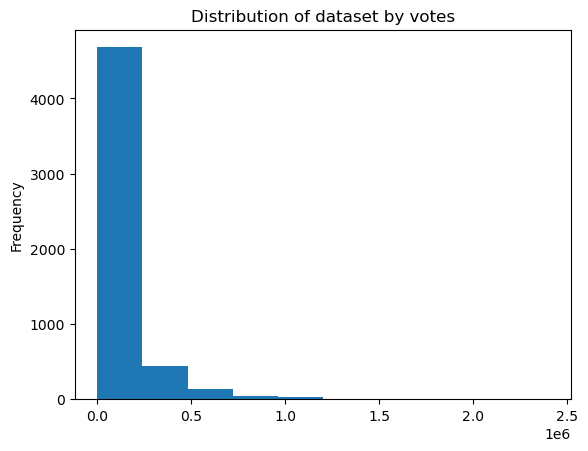

In [10]:
data['votes'].plot(kind='hist', title='Distribution of dataset by votes')

In [11]:
data['votes'].describe().apply("{0:.2f}".format)

count       5359.00
mean      115823.93
std       185011.57
min          195.00
25%        19000.00
50%        53000.00
75%       131000.00
max      2400000.00
Name: votes, dtype: object

We noticed that the distribution of votes was highly skewed. However, this is not anomalous given that movies with higher scores tend to receive more votes due to more exposure.

While exploring the data, we also noticed that there were a few unusual values for the rating attribute, namely 
"TV-MA", "NC-17", and "X". These rating outliers will be addressed in our "Feature Engineering" section below.

In [12]:
data['rating'].value_counts() 

R        2597
PG-13    1729
PG        907
G         111
NC-17      12
TV-MA       2
X           1
Name: rating, dtype: int64

We then examine the data for any correlations between continuous values. This will be useful when determining which features to use for our modeling algorithms and whether we can perform dimension reduction on any columns.

In [13]:
features = data.copy()
features = features.drop(columns=['score'])
features.corr()

/var/folders/ps/frvdw_b12331xc41xqrqbff80000gn/T/ipykernel_35692/4050368262.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  features.corr()


,year,votes,budget,gross,runtime
year,1.000000,0.207662,0.330342,0.275968,0.073406
votes,0.207662,1.000000,0.439428,0.615622,0.358178
budget,0.330342,0.439428,1.000000,0.739373,0.323501
gross,0.275968,0.615622,0.739373,1.000000,0.279794
runtime,0.073406,0.358178,0.323501,0.279794,1.000000


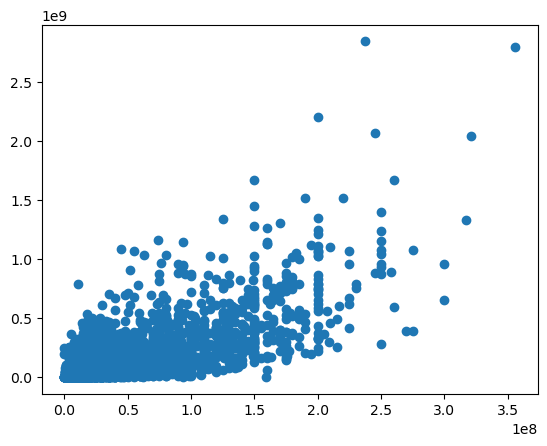

In [14]:
# Plot correlation between budget and gross (scaled)
# data.plot.scatter(x='budget', y='gross')
plt.scatter(x=data['budget'], y=data['gross'])
# plt.yticks(np.arange(0, 3e9, step=1e9))
plt.show()

There is a strong positive correlation of 0.74 between budget and gross, as displayed in the scatterplot. During feature engineering, we will combine these into one feature in order to reduce the number of dimensions. 

## Feature Engineering 

First, we wanted to resolve the rating outliers we discovered while exploring our data. After further research, we found that all our outlier values shared similar definitions to the more frequent "R" rating. Since they all refer to mature audiences, we decided to group them all as "R" to create a clearer pattern in the data for our modeling algorithms to use.

In [15]:
data = data.replace("TV-MA", "R")
data = data.replace("NC-17", "R")
data = data.replace("X", "R")

We also decided to create a new column 'profits' and drop the columns 'gross' and 'budget' in order to reduce the dimensions by 1 and prevent overfitting on monetary data.

In [16]:
data['profits'] = data['gross'] - data['budget']
data = data.drop(columns=['gross','budget'])
data.head()

,rating,genre,year,released,score,votes,director,writer,star,country,company,runtime,profits
0,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,Warner Bros.,146.0,27998772.0
1,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,Columbia Pictures,104.0,54353106.0
2,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,Lucasfilm,124.0,520375067.0
3,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,Paramount Pictures,88.0,79953539.0
4,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,Orion Pictures,98.0,33846344.0


We then did some more feature creation using the released attribute. We created features for release month, storing it as a pair of sine and cosine features in order to represent its cyclical nature.

In [17]:
def encode_time(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

# remove all records that are not in the "month day, year (country)" format for the released column
data['length'] = data['released'].str.count(" ")
data = data[data['length'] >= 3]

# extract month from released
data[['month', 'rest']] = data['released'].str.split(' ', n=1, expand=True)
data = data.drop(columns=['released', 'rest'])

# mapping string month to numerical value
month_dict = {'January':1,
             'February':2,
             'March':3,
             'April':4,
             'May':5,
             'June':6,
             'July':7,
             'August':8,
             'September':9,
             'October':10,
             'November':11,
             'December':12}

data['month'] = data['month'].map(month_dict)

# create cyclical features for month
encode_time(data, 'month', 12)
labels = data['score']
data = data.drop(columns=['month', 'length', 'score'])
data.head()

,rating,genre,year,votes,director,writer,star,country,company,runtime,profits,month_sin,month_cos
0,R,Drama,1980,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,Warner Bros.,146.0,27998772.0,1.224647e-16,-1.000000
1,R,Adventure,1980,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,Columbia Pictures,104.0,54353106.0,-5.000000e-01,-0.866025
2,PG,Action,1980,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,Lucasfilm,124.0,520375067.0,1.224647e-16,-1.000000
3,PG,Comedy,1980,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,Paramount Pictures,88.0,79953539.0,-5.000000e-01,-0.866025
4,R,Comedy,1980,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,Orion Pictures,98.0,33846344.0,-5.000000e-01,-0.866025


In [18]:
# reset index
data = data.reset_index()
data = data.drop(columns=['index'])

We then convert categorical features into numerical ones.
<br>
For the rating feature, we first ordinally mapped ratings to values 1, 2, 3, and 4, since there is a natural order to this attribute.

In [19]:
rating_dict = {
    'G': 1,
    'PG': 2,
    'PG-13': 3,
    'R': 4
}
data_encoded = data.copy()
data_encoded['rating_num'] = data_encoded['rating'].map(rating_dict)
data_encoded = data_encoded.drop(columns=['rating'])
data_encoded.head()

,genre,year,votes,director,writer,star,country,company,runtime,profits,month_sin,month_cos,rating_num
0,Drama,1980,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,Warner Bros.,146.0,27998772.0,1.224647e-16,-1.000000,4
1,Adventure,1980,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,Columbia Pictures,104.0,54353106.0,-5.000000e-01,-0.866025,4
2,Action,1980,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,Lucasfilm,124.0,520375067.0,1.224647e-16,-1.000000,2
3,Comedy,1980,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,Paramount Pictures,88.0,79953539.0,-5.000000e-01,-0.866025,2
4,Comedy,1980,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,Orion Pictures,98.0,33846344.0,-5.000000e-01,-0.866025,4


Next, we used one hot encoding to number our genre column. This is because there are only 15 genres, and thus only 14 additonal columns will be created (once we drop 'genre').

In [20]:
print("Number of unique genres:", len(pd.unique(data['genre'])))

Number of unique genres: 15


The following pie chart displays the distribution of genres:

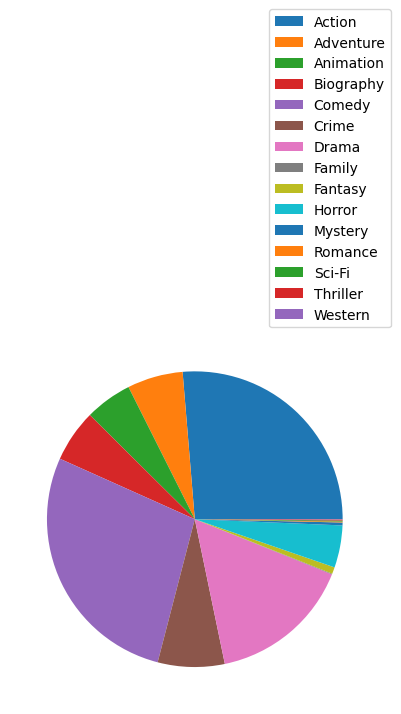

In [21]:
genre = data.groupby('genre')
sizes = genre.size()

plt.pie(sizes, labels=['Action', 'Adventure', 'Animation', 'Biography','Comedy','Crime','Drama','Family','Fantasy','Horror','Mystery','Romance','Sci-Fi','Thriller','Western'], labeldistance=None)
plt.legend(bbox_to_anchor=(1.05, 1),loc='lower right')
plt.show()

In [22]:
data_encoded = pd.get_dummies(data_encoded, columns=['genre'], drop_first=False)
data_encoded.head()

,year,votes,director,writer,star,country,company,runtime,profits,month_sin,...,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_Western
0,1980,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,Warner Bros.,146.0,27998772.0,1.224647e-16,...,0,1,0,0,0,0,0,0,0,0
1,1980,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,Columbia Pictures,104.0,54353106.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
2,1980,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,Lucasfilm,124.0,520375067.0,1.224647e-16,...,0,0,0,0,0,0,0,0,0,0
3,1980,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,Paramount Pictures,88.0,79953539.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
4,1980,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,Orion Pictures,98.0,33846344.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0


We then perform feature transformation on 'director', 'writer', 'star', 'country', and 'company' by turning them from strings (representing names, film companies, etc.) to numerical frequency counts. This is because these columns have many unique values and thus should not be one hot encoded. We used CountEncoder from the category_encoders library to accomplish this.

In [23]:
!pip install category_encoders
from category_encoders import CountEncoder

data_encoded = CountEncoder(cols=['director', 'writer', 'star', 'country', 'company']).fit(data_encoded).transform(data_encoded)
data_encoded.head()

,year,votes,director,writer,star,country,company,runtime,profits,month_sin,...,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_Western
0,1980,927000.0,2,29,18,485,298,146.0,27998772.0,1.224647e-16,...,0,1,0,0,0,0,0,0,0,0
1,1980,65000.0,4,2,4,4290,302,104.0,54353106.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
2,1980,1200000.0,3,1,2,4290,10,124.0,520375067.0,1.224647e-16,...,0,0,0,0,0,0,0,0,0,0
3,1980,221000.0,6,6,3,4290,279,88.0,79953539.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
4,1980,108000.0,9,2,16,4290,46,98.0,33846344.0,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0


## Modeling

We will now attempt to predict scores using 5 different models: linear regression, decision trees, neural nets, KNN, and SVR.

### Linear Regression

We decided to start with linear regression since we are predicting a continous target and noticed correlations between features while exploring the data.

In [40]:
def get_adj_r2(r2, n, p):
    return (1-(1-r2)*((n-1)/(n-p-1)))

from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
labels_reg = labels.values.reshape(-1,1)
# r2 = cross_val_score(model, data_encoded, labels_reg)
scores = cross_validate(model, data_encoded, labels_reg, cv=5, scoring= ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])

# r2_avg = r2.sum()/ len(r2)
# print("R2:", r2_avg)
r2_avg = scores["test_r2"].mean()
print("R2:", r2_avg)
adj_r2 = get_adj_r2(r2_avg, data_encoded.shape[0], data_encoded.shape[1])
print("Adjusted R2:", adj_r2)
print("MAE:", scores["test_neg_mean_absolute_error"].mean() * -1)
print("RMSE:", scores["test_neg_root_mean_squared_error"].mean() * -1)

R2: 0.36094994568121097
Adjusted R2: 0.35771030026878003
MAE: 0.5794501093365377
RMSE: 0.7652884584125175


The relatively low R2 score indicates that only 35% of the variance in scores is explained by our features when using a linear regression model. Therefore, this model is not the most suitable for this task.

### Decision Trees

We chose to try a decision tree next since handling the data linearly using linear regression was not effective.

In order to use a decision tree, we must bin our continous target value (scores, stored as floats) into categorical target values (scores, stored as ints ranging from 0 to 10).

In [25]:
labels_tree = labels.round(0).astype(int)

We first create a decision tree to perform hyperparameter tuning using grid search.

In [26]:
!pip install imblearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

smote = SMOTE()
clf = DecisionTreeClassifier()
pipeline = imbpipeline(steps=[('smote', smote),  ('clf', clf)])

params = {"clf__max_depth": [5,10,15,20,25,30], 
          "clf__min_samples_leaf": [20,25,30,35,40,45],
          "clf__max_features": [14,20,26]}


grid_search = GridSearchCV(pipeline, params, cv=5, scoring='accuracy')
#nested_score = cross_val_score(grid_search, data_tree, labels_tree, cv=5)

grid_search.fit(data_encoded, labels_tree)

print(type(grid_search.best_params_))
print(grid_search.best_params_)

print("Accuracy:", grid_search.best_score_*100)
tree_params = grid_search.best_params_


#print("Accuracy:", nested_score.mean())

<class 'dict'>
{'clf__max_depth': 25, 'clf__max_features': 20, 'clf__min_samples_leaf': 20}
Accuracy: 37.35602153634039


Our model correctly predicts the score about 37% of the time. This likely indicates that our dataset is difficult to predict, but we will continue trying other models to see if our accuracy can be improved.
<br><br>
One reason the accuracy is low may be because we turned a continous classification problem into a categorical one by using a decision tree with a rounded version of the correct score.

In [27]:
# Since our accuracy was low, we decided to evaluate how far off, on average, our decision tree predictions were compared to the (rounded) true labels. This revealed that the decision tree performed quite well since y_pred was only 0.6 off from the y_test label.

In [28]:
# X_train, X_test, y_train, y_test = train_test_split(data_encoded, labels_tree, test_size=0.30)

# clf = DecisionTreeClassifier(max_depth=tree_params['max_depth'], max_features=tree_params['max_features'], min_samples_leaf=tree_params['min_samples_leaf'])
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [29]:
# total_diff = 0
# for i in range(len(y_pred)):
#     total_diff += abs(y_pred[i] - y_test.iloc[i])
# avg_diff = total_diff / len(y_pred)
# print("Distance from correct category:", avg_diff)

In [30]:
# from sklearn.metrics import classification_report, confusion_matrix

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

After our data prep and feature engineering, the range of our scores have decreased, which is why there are only 8 categories for our decision tree:

In [31]:
print("Min score:", labels.min())
print("Max score:", labels.max())
print(pd.unique(labels_tree))

Min score: 1.9
Max score: 9.3
[8 6 9 7 5 4 3 2]


In [32]:
# Precision: The higher precision for categories 6 to 8 indicates that the decision tree

For our remaining models, we will attempt to use continous target values to see if we can improve our accuracy. However, this means we can no longer use SMOTE to create a more well-balanced dataset. While we considered alternatives such as SMOGN, there is little research/information on how to use these tools and how to apply them within a pipeline. Therefore, we've decided to use our dataset as is.

### Neural Nets
<br>
Since neural networks can learn complex decision boundaries and handle redundant attributes, we decided to try this next. We will use the the scikit learn MLPRegressor to output continuous values for IMDb scores.

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate

scaler = StandardScaler()
mlp = MLPRegressor()
pipeline = Pipeline(steps=[('scaler', scaler),  ('mlp', mlp)])

param_grid = {
    #'mlp__hidden_layer_sizes': list(range(30, 70, 10)),
    #'mlp__activation': ['logistic', 'tanh', 'relu', 'identity']
    'mlp__hidden_layer_sizes': list(range(50, 60, 10)),
    'mlp__activation': ['logistic']
}
#params: 50, logistic
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
#grid_search.fit(data_nn, labels)
scores = cross_validate(grid_search, data_encoded, labels, cv=5, scoring= ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
print(scores)
#print(grid_search.best_params_)
#print(grid_search.best_score_)
print("MAE:", scores["test_neg_mean_absolute_error"].mean() * -1)
print("RMSE:", scores["test_neg_root_mean_squared_error"].mean() * -1)

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

{'fit_time': array([ 9.68318009,  9.91086292, 10.00928116,  9.28036809,  9.21708012]), 'score_time': array([0.00352907, 0.00432992, 0.00296402, 0.00328183, 0.00317287]), 'test_r2': array([0.3583573 , 0.49426629, 0.48310567, 0.48707949, 0.31009944]), 'test_neg_mean_absolute_error': array([-0.59457437, -0.51959303, -0.52917516, -0.49780698, -0.57672695]), 'test_neg_root_mean_squared_error': array([-0.76299219, -0.6966204 , -0.74679804, -0.68556365, -0.71979154])}
Accuracy: 42.658163812505734
Accuracy: -0.5435752983563884
Accuracy: -0.7223531639058354


/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### K-Nearest Neighbors

In [36]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

pca = PCA()
neigh = KNeighborsRegressor()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', neigh)])


param_grid = {
    'pca__n_components': list(range(5, 26)),
    'knn__n_neighbors': list(range(1, 25))
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
#grid_search.fit(data_knn, labels) #all?
#print(grid_search.best_params_)
#print(grid_search.best_score_)

scores = cross_validate(grid_search, data_encoded, labels, cv=5, scoring= ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
print("MAE:", scores["test_neg_mean_absolute_error"].mean() * -1)
print("RMSE:", scores["test_neg_root_mean_squared_error"].mean() * -1)


Accuracy: 29.860651830900082
Accuracy: -0.6165446763116336
Accuracy: -0.8009110020318836


### SVR

In [41]:
from sklearn.svm import SVR

svr = SVR()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svr', svr)])

param_grid = {
    'pca__n_components': list(range(5, 26)),
    'svr__kernel': ['linear', 'rbf', 'poly','sigmoid', 'precomputed']
    #'svr__epsilon': [0.1, 0.15, 0.2, 0.25],
    #'svr__C': [1.0, 1.5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
#grid_search.fit(data_svr, labels)
#print(grid_search.best_params_)
#print(grid_search.best_score_)

scores = cross_validate(grid_search, data_encoded, labels, cv=5, scoring= ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
print("MAE:", scores["test_neg_mean_absolute_error"].mean() * -1)
print("RMSE:", scores["test_neg_root_mean_squared_error"].mean() * -1)

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
105 fits failed out of a total of 525.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/svm/_base.py", line 217

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
105 fits failed out of a total of 525.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/svm/_base.py", line 217

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
105 fits failed out of a total of 525.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/svm/_base.py", line 217

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
105 fits failed out of a total of 525.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/svm/_base.py", line 217

/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
105 fits failed out of a total of 525.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/andreat/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/svm/_base.py", line 217

MAE: 0.5432702136759826
RMSE: 0.7350425850617605


## Comparing our Models

### Predicting a continous score:

**Linear Regression**
<br>
R2: 0.36094994568121097<br>
Adjusted R2: 0.35771030026878003<br>
MAE: 0.5794501093365377<br>
RMSE: 0.7652884584125175

**MLPRegressor Neural Network**
<br>
MAE: 0.5435752983563884<br>
RMSE: 0.7223531639058354

**KNeighborsRegressor**
<br>
MAE: 0.6165446763116336<br>
RMSE: 0.8009110020318836

**SVR**
<br>
MAE: 0.5432702136759826<br>
RMSE: 0.7350425850617605

The xxx model had the lowest MAE and RMSE, and is thus the best model to use for prediciting scores based off Movie Industry dataset attributes. However, even the best model performed poorly, which indicates that it is difficult to use this dataset's features to predict scores. Some solutions that may improve our model's ability to make accurate predicitions could be to increase the number of records in the dataset in order to make trends in the data more apparent. Having a better balanced dataset could also help.


### Predicting a categorical score:

**Decision Tree**
<br>
Accuracy: 37.35602153634039%
<br>
